**Recommender system-collaborative filtering module:**<br>

With user_id x restaurant_id rating matrix, build a collaborative filtering recommender module. Remember that the dataset has a total of 1,518,169 users, 188,593 businesses and 5,996,995 reviews. In terms of the user_id x business_id matrix, the matrix is very sparse (0.003% non-empty). Therefore, matrix factorization algorithm is used to complete the matrix and generate recommendations.<br>

* Metrics chosen for evaluating the ‘goodness’ of the algorithms:<br>
RMSE(root mean squared error) is used here to measure rating prediction accuracy.

In [1]:
import pandas as pd
import numpy as np
import pickle
%matplotlib inline
import matplotlib.pyplot as plt

business = pd.read_csv('business_clean.csv')  # contains business data including location data, attributes and categories
review = pd.read_csv('review_clean.csv') # contains full review text data including the user_id that wrote the review and the business_id the review is written for

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# 1. Adjusted rating

Here, a single metric is introduced as a substitute of the original average restaurant rating ('stars' column of the business dataframe). Ideally, the new metric should take into consideration: <br>
1) average rating of the restaurant (indicates the goodness of the restaurant, but does not consider popularity) <br>
2) # of ratings by users (indicates popularity, but does not imply the goodness of the restaurant) <br>
3) age of the rating (indicates the relevance of the rating, as outdated ratings might fail to indicate the actual quality)<br>

The proposed new score is: 
$$score_i = \frac{\sum_u r_{ui} + k*\mu}{n_i+k}$$

where $r_ui$ is the rating on item i by user u, $n_i$ is the number of rating on item i, $\mu$ is the global mean of ratings over all businesses and all users and k is the strength of the damping term.

As the equation shows, the adjusted score uses the mechanism of the damped mean to regulate the extreme cases of having only a few extreme ratings. k controls the strength of the damping effect: the larger k is, the more actual ratings are required to overcome the global mean.

In this case, k is set to 4 (which is the 10% quantile of the review counts for all businesses), but it can be tuned according to various business considerations.  

Note:<br> 
Here, the age of the rating is not adjusted in the current version of the proposed metric. This is because 90% of the reviews/ratings are from year 2011 and later, and are considered quite relevant. Therefore, the need of adjusting for the age of the ratings is not strong.

In [2]:
# compute globe mean ratings of all businesses and all reviews
globe_mean = ((business.stars * business.review_count).sum())/(business.review_count.sum())
print("global mean rating is:", globe_mean)

global mean rating is: 3.7277814701620127


In [3]:
print(business.review_count.quantile([0.1,0.25,0.5,0.75,0.9]))
k = 22 # set strength k to 22, which is the 50% quantile of the review counts for all businesses
business['adjusted_score'] = (business.review_count * business.stars + k * globe_mean)/(business.review_count + k)
print("\nrank by the adjusted score in descending order:")
print(business[['review_count','stars','adjusted_score']].sort_values('adjusted_score', ascending=False).head(5))
print("\nrank by the original score in descending order:")
print(business[['review_count','stars','adjusted_score']].sort_values('stars', ascending=False).head(5))
print("\nrank by the least number of reviews:")
print(business[['review_count','stars','adjusted_score']].sort_values('review_count', ascending=True).head(5))

0.10      4.0
0.25      8.0
0.50     22.0
0.75     66.0
0.90    172.0
Name: review_count, dtype: float64

rank by the adjusted score in descending order:
       review_count  stars  adjusted_score
7464           1746    5.0        4.984169
31910          1380    5.0        4.980037
45401           547    5.0        4.950811
7784            520    5.0        4.948360
28162           472    5.0        4.943342

rank by the original score in descending order:
       review_count  stars  adjusted_score
22115             7    5.0        4.034869
23114             5    5.0        3.963377
42990             5    5.0        3.963377
42989            16    5.0        4.263452
12778             3    5.0        3.880448

rank by the least number of reviews:
       review_count  stars  adjusted_score
0                 3    4.5        3.820448
5707              3    4.0        3.760448
16594             3    4.0        3.760448
5699              3    3.5        3.700448
16605             3    3.5  

# 2. User-restaurant Matrix factorization

## 2.1 preparation

### 2.1.1 check business_id

In [4]:
print("# of restaurants in the business dataset: ", business.business_id.nunique())
print("# of businesses in the review dataset: ", review.business_id.nunique())

# of restaurants in the business dataset:  47553
# of businesses in the review dataset:  188593


In [5]:
b_bid = set(business.business_id.values) # set of unique business_id in the 'business' dataset
r_bid = set(review.business_id.values) # set of unique business_id in the 'review' dataset
len(b_bid) == len(b_bid.intersection(r_bid))

True

As shown, all the restaurant 'business_id' from the 'business' dataset can be found in the 'review' dataset, that is, every restaurant in the catalog has rated by at least one user. 

In [6]:
review_partial = review[review.business_id.isin(list(business.business_id.unique()))].reset_index(drop=True)

In [7]:
print(len(review))
print(len(review_partial))

5996995
3469589


In [8]:
print(review.user_id.nunique())
print(review_partial.user_id.nunique())

1518168
988296


As shown, the 'review' dataframe contains many reviews on non-restaurant businesses. But if filtering the 'review' df by only restaurant related reviews, then the user coverage drops significantly to only 65% of the original coverage. Therefore, the entire 'review' dataframe will be used in collaborative filtering for the maximum user coverage.  

### 2.1.2 check unique user - restaurant combination

In [9]:
# doublecheck that there is only one review for each user_id, business_id combinations before pivoting to user x restaurant matrix
review[review.duplicated(['user_id','business_id'], keep=False)]

,funny,stars,useful,cool,text,business_id,user_id,review_id,date
2055037,0,1,0,0,"This place continues to be a shit hole, with P...",xKQVtEWiPK6hq0DljVnAfg,XNzChtoNOw706kps82x0Kg,1l-mU-BwQsZRW7BKdHVwZw,2017-05-02
2055038,0,1,8,0,My mother recently spent a good deal of time i...,xKQVtEWiPK6hq0DljVnAfg,XNzChtoNOw706kps82x0Kg,IcpPtd37iJEthZybuasS4g,2015-02-06
4591943,0,5,0,0,I had someone give me a facial and ruined my f...,V_oOjMVRXnr_t_9i1CSivw,8GpM-QUlb0V9DP56Xse3EA,I8v-5jfkBluyN5kT8ha0bA,2016-08-26
4591944,1,5,2,0,I had someone give me a facial and ruined my f...,V_oOjMVRXnr_t_9i1CSivw,8GpM-QUlb0V9DP56Xse3EA,6vc4tqVh9_tbMRtFeS4pIw,2016-07-09
5154278,0,5,0,1,I always stop by DFEF for my morning fix every...,7MacgLhLGiXvZoZdhgeKPw,lLF9x4I41LFFKa_FX-lkbQ,HFgn9Wz2jydIZLtqUeGu0Q,2017-06-03
5154279,0,5,1,0,I always stop by DFEF for my morning fix every...,7MacgLhLGiXvZoZdhgeKPw,lLF9x4I41LFFKa_FX-lkbQ,HR1JWyemX-kmNFaQ5LxR2g,2017-01-03


As shown, there are three user, restaurant combinations having two reviews each (at different timestamp with different text contents) instead of one. This means that Yelp allows a user  to review a business multiple times. In this case, the repeated reviews share the same star ratings as the originial, therefore, we only need the keep the first rating. (Otherwise, we need to replace it with the averaged rating instead)

In [10]:
# create a reduced copy by removing the duplicated user, restaurant rating combinations
review_r = review[~review.duplicated(['user_id','business_id'], keep='first')]
review_r.reset_index(inplace=True, drop=True)

In [11]:
print(len(review))
print(len(review_r))

5996995
5996992


### 2.1.3 train test split

In [55]:
# train-test split by randomly split on user-restaurant rating combination, and load into Surprise individually
idx = list(review_r.index)
np.random.shuffle(idx) # shuffle the list of index

# 90% trainset, 10% testset
threshold = int(0.9 * len(review_r))                                    
trainset = review_r.loc[idx[:threshold],['user_id','business_id','stars']]                             
testset = review_r.loc[idx[threshold:],['user_id','business_id','stars']]

In [56]:
print("# of users in total:" , review_r.user_id.nunique())
print("# of users in the training set: ", trainset.user_id.nunique())
print("# of restaurants in total:" , review_r.business_id.nunique())
print("# of restaurants in the training set: ", trainset.business_id.nunique())

# of users in total: 1518168
# of users in the training set:  1435047
# of restaurants in total: 188593
# of restaurants in the training set:  188544


Note: the training data doesn't include all users and all restaurants either. But this can be handled by Surprise package and it returns the global mean of the training data if the user_id or the business_id to be predicted is not found in the training data.

## 2.2 matrix factorization using scikit-surprise package

Here, instead of starting from scratch, scikit-surprise package is used to handle some of the implementation details. 
Surprise is a Python scikit building and analyzing recommender systems. http://surpriselib.com/

In [14]:
from surprise import Dataset, Reader
from surprise import NMF, SVD
from surprise.model_selection import cross_validate, GridSearchCV, KFold
from surprise import accuracy

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [15]:
# load trainset and testset into Surprise

# create a Reader object with the rating_scale from 1 to 5
reader = Reader(rating_scale=(1, 5))

# load trainset, note: the columns must correspond to user id, item id and ratings in the exact order
data_train = Dataset.load_from_df(trainset, reader)
training = data_train.build_full_trainset() # prepare a trainset object out of the training data to feed to .fit() method

# load testset
data_test = Dataset.load_from_df(testset, reader)
testing = data_test.construct_testset(data_test.raw_ratings) # prepare a testset object out of the test data to feed to .test() method

### 2.2.1 SVD algorithm without bias

The matrix factorization without bias (Probabilistic Matrix Factorization) is achieved by using the SVD algorithm and setting the biased parameter to False. 
That is the rating is predicted as: 
$$r̂_ui=q^T_ip_u$$
where $p_u$ is the user latent factor matrix, $q_i$ is the item latent factor matrix.
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [16]:
%%time
# SVD with defaults

svd = SVD(n_factors=20, n_epochs = 30, biased=False, verbose=True) # initiate a SVD algorithm object

svd.fit(training) # training on the trainset
pred_svd = svd.test(testing) # predict ratings for the testset
accuracy.rmse(pred_svd) # compute RMSE score

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
RMSE: 1.6135
CPU times: user 4min 21s, sys: 3.91 s, total: 4min 25s
Wall time: 4min 31s


In [17]:
# user and item matrix with latent features
user_latent = svd.pu
item_latent = svd.qi
print(user_latent.shape)
print(item_latent.shape)

(1435339, 20)
(188543, 20)


(188543,)
mean predicted rating: 0.8679802167989213
[(14772, 7.8386661444468775), (11270, 7.499784853238998), (10622, 7.141662937889348), (33252, 7.023713756892179), (33270, 6.936848190934862), (17994, 6.828225552807853), (43143, 6.810920034467644), (17072, 6.742314372288877), (31287, 6.66459029951559), (8553, 6.567162470393413)]
[(1005, -4.20402591745137), (35215, -4.250162187465908), (37625, -4.263576513020702), (68484, -4.347674644958943), (12828, -4.372068890938771), (50243, -4.5150399652285955), (38397, -4.738308043277228), (43449, -4.822115864841333), (27178, -5.340955631000047), (19838, -5.518231962483538)]


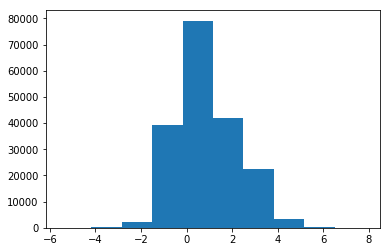

In [23]:
# spot check on known user
u_id = training.to_inner_uid('CxDOIDnH8gp9KXzpBHJYXw')
prediction = np.dot(user_latent[u_id,:],item_latent.T)
print(prediction.shape)
print("mean predicted rating:", sum(prediction)/len(prediction))

# # adjust for rating offset
# prediction -= svd_bias.trainset.offset # Here: offset = 0 

# plot distribution of predicted ratings for the user
plt.hist(prediction);

# sort and look at the top 10 highest and lowest ratings
prediction_s = list(zip(np.arange(len(prediction)),prediction))
prediction_s = sorted(prediction_s, key=lambda x: x[1], reverse=True)
print(prediction_s[:10]) # 10 highest predicted ratings
print(prediction_s[-10:]) # 10 lowest predicted ratings

In [27]:
# spot check on unknown user
prediction = [svd.trainset.global_mean] * item_latent.shape[0]
print(svd.trainset.global_mean)

3.7361912233023524


The global mean rating computed from the trainset will be returned as the prediction for all restaurants for unknown users.

3.2187750735490774

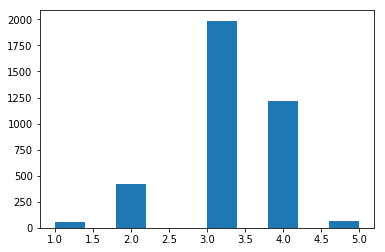

In [20]:
# compare to actual ratings of the user
plt.hist(review_r[review_r.user_id == 'CxDOIDnH8gp9KXzpBHJYXw'].stars);
review_r[review_r.user_id == 'CxDOIDnH8gp9KXzpBHJYXw'].stars.mean()

As shown, the predicted ratings from the SVD without bias centered around rating of 0-1, with a mean of 0.87 and a range of -5.5 to 7.8. This is not a good match of the actual ratings centerd around 3-4 with a mean of 3.2 and a range of 1-5. 

### 2.2.2 SVD algorithm with bias
Similar to 2.2.1, scikit-surprise package is used to handle some of the implementation details.

The matrix factorization with bias is achieved by using the SVD algorithm and setting the biased parameter to True. 
That is the rating is predicted as: 
$$r̂_ui=μ+bu+bi+q^T_ip_u$$
where $p_u$ is the user latent factor matrix, $q_i$ is the item latent factor matrix, bu is the bias terms for users, bi is the bias terms for items. 
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD

In [22]:
%%time
# SVD with defaults

svd_bias = SVD(n_factors=20, n_epochs = 30, biased=True, verbose=True) # initiate a SVD algorithm object with the bias terms

svd_bias.fit(training) # training on the trainset
pred_svd_bias = svd_bias.test(testing) # predict ratings for the testset
accuracy.rmse(pred_svd_bias) # compute RMSE score

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
RMSE: 1.2743
CPU times: user 4min 13s, sys: 3.61 s, total: 4min 17s
Wall time: 4min 21s


In [28]:
# extract global mean rating from trainset
mean = svd_bias.trainset.global_mean

# user and item matrix with latent features
user_latent = svd_bias.pu
item_latent = svd_bias.qi
print(user_latent.shape)
print(item_latent.shape)

# user and item bias vector
user_bias = svd_bias.bu
item_bias = svd_bias.bi
print(user_bias.shape)
print(item_bias.shape)

(1435339, 20)
(188543, 20)
(1435339,)
(188543,)


[3.51639793 2.95304187 3.88066392 3.48111165 3.74012314 4.1815483
 2.5351963  2.40812977 4.33645222 4.15999479]
(188543,)
mean predicted rating:  3.2349401276402827
[(16960, 4.776904955441582), (9208, 4.753047030626503), (799, 4.709718737241246), (57018, 4.668016722428178), (87427, 4.667323267232501), (20730, 4.664409207947162), (13199, 4.658240098113386), (83436, 4.653560234582426), (22575, 4.647589422772136), (1644, 4.646388580030081)]
[(26411, 0.7252939650199545), (16114, 0.7227827760769804), (31986, 0.7175943253093953), (33893, 0.7102716003236218), (21622, 0.6649547635183295), (39313, 0.6552640395348124), (17238, 0.6284526510250125), (5329, 0.6190846927976407), (6428, 0.5693175236198391), (38528, 0.518261876280907)]


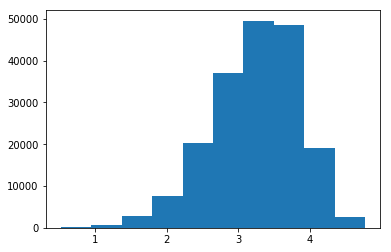

In [29]:
# spot check-known user

u_id = training.to_inner_uid('CxDOIDnH8gp9KXzpBHJYXw')
prediction = mean + user_bias[u_id] + item_bias + np.dot(user_latent[u_id,:],item_latent.T)
print(prediction[:10])
print(prediction.shape)
print("mean predicted rating: ", sum(prediction)/len(prediction))

# # adjust for rating offset
# prediction -= svd_bias.trainset.offset # Here: offset = 0

# plot distribution of predicted ratings for the user
plt.hist(prediction);

# sort and look at the top 10 highest and lowest ratings
prediction_s = list(zip(np.arange(len(prediction)),prediction))
prediction_s = sorted(prediction_s, key=lambda x: x[1], reverse=True)
print(prediction_s[:10]) # 10 highest predicted ratings
print(prediction_s[-10:]) # 10 lowest predicted ratings

[4.01775148 3.49406036 4.5795215  3.82375677 4.24074412 4.48460394
 2.86036996 3.39117686 4.06482679 4.54554207]
(188543,)
mean predicted rating: 3.6804884705358365
[(87569, 5.035666210963752), (87427, 5.025696153995782), (17573, 5.014711069967262), (34351, 5.0135506563034635), (100638, 5.013506402209361), (44388, 5.013226154600245), (11415, 5.011160670775523), (59599, 5.009751690303481), (7130, 5.009032580842581), (69363, 5.008989424852158)]
[(36884, 1.2103612579271634), (15166, 1.2085272840308687), (33893, 1.2082994453689806), (61801, 1.2070187301795658), (47134, 1.198404296326415), (33268, 1.1926833439572828), (17238, 1.175608672085608), (31389, 1.1498671333882853), (21622, 1.1426537715768759), (38528, 1.121461461090782)]


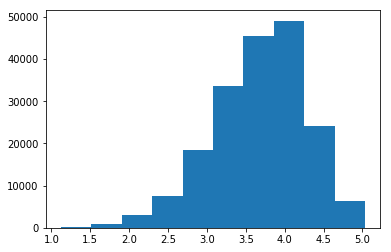

In [31]:
# spot check-unknown user

prediction = mean + item_bias
print(prediction[:10])
print(prediction.shape)
print("mean predicted rating:", sum(prediction)/len(prediction))

# # adjust for rating offset
# prediction -= svd_bias.trainset.offset # Here: offset = 0 

# plot distribution of predicted ratings for the user
plt.hist(prediction);

# sort and look at the top 10 highest and lowest ratings
prediction_s = list(zip(np.arange(len(prediction)),prediction))
prediction_s = sorted(prediction_s, key=lambda x: x[1], reverse=True)
print(prediction_s[:10]) # 10 highest predicted ratings
print(prediction_s[-10:]) # 10 lowest predicted ratings

3.2187750735490774

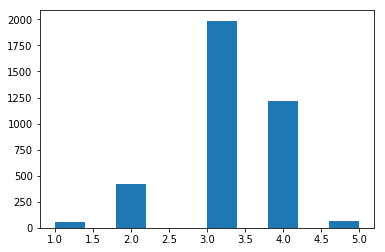

In [32]:
# compare to actual ratings of the user
plt.hist(review_r[review_r.user_id == 'CxDOIDnH8gp9KXzpBHJYXw'].stars);
review_r[review_r.user_id == 'CxDOIDnH8gp9KXzpBHJYXw'].stars.mean()

As shown, the predicted ratings from the SVD with bias terms show a much better improvement. Predicted ratings center around rating of 3-4, with a mean of 3.23 and a range of 0.52 to 4.78, a good match of the actual ratings centerd around 3-4 with a mean of 3.2 and a range of 1-5.
On the other hand, the predicted ratings for unseen users is centered around 3-4.5 with a mean of 3.68 and a range of 1.12-5.04, a good match to the global mean of 3.74 as well. 

In [33]:
# %%time

# # parameter optimization with scikit-surprise SVD algorithm with bias

# # cross validation to optimize parameters of SVD with bias
# param_grid = {'n_factors': [10,20,30,50], 'n_epochs': [50], 'lr_all': [0.005],'reg_all': [0.01, 0.02, 0.05], 'biased': [True]}
# svd_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=KFold(3, random_state=42),joblib_verbose=2)
# svd_gs.fit(data_train) # gridsesarch optimization on the trainset

# # best RMSE score
# print(svd_gs.best_score)
# # combination of parameters that gave the best RMSE score
# print(svd_gs.best_params)

# svd_gs_best = svd_gs.best_estimator['rmse']  # algorithm with the optimized parameters
# svd_gs_best.fit(training)
# pred_svd_gs_best = svd_gs_best.test(testing) 
# accuracy.rmse(pred_svd_gs_best)

### 2.2.3 NMF algorithm (without bias)

Similar to 2.2.1, scikit-surprise package is used to handle some of the implementation details.

The non-negative matrix factorization (NMF) is achieved by using the NMF algorithm. The default without user and item bias terms is used here. 
https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF

In [34]:
%%time
# NMF without bias

nmf = NMF(n_factors=20, n_epochs = 30, biased=False, verbose=True) # initiate a NMF algorithm object

nmf.fit(training) # training on the trainset
pred_nmf = nmf.test(testing) # predict ratings for the testset
accuracy.rmse(pred_nmf) # compute RMSE score

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
RMSE: 1.4253
CPU times: user 6min 15s, sys: 12.4 s, total: 6min 28s
Wall time: 6min 33s


In [35]:
# user and item matrix with latent features
user_latent = nmf.pu
item_latent = nmf.qi
print(user_latent.shape)
print(item_latent.shape)

(1435339, 20)
(188543, 20)


(188543,)
mean predicted rating:  3.408266266857016
[(61037, 6.420736467636237), (185447, 6.287767090763864), (148743, 6.2601015726749525), (91398, 6.244302931721499), (177074, 6.204474784831942), (86922, 6.203609073532165), (164524, 6.1261237760251674), (188370, 6.105899765784667), (162852, 5.980052106772009), (58773, 5.977768593382456)]
[(130998, 0.5667920883701845), (187131, 0.5577636855854239), (79532, 0.5380795875505566), (171946, 0.532834736285226), (118789, 0.5252774000378253), (182520, 0.5216862631036636), (148589, 0.5187627748614838), (109670, 0.48534016964374277), (183330, 0.47606334213165613), (185052, 0.4393604135423561)]


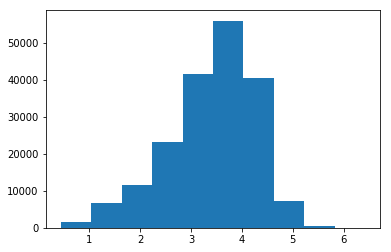

In [37]:
# spot check on known user
u_id = training.to_inner_uid('CxDOIDnH8gp9KXzpBHJYXw')
prediction = np.dot(user_latent[u_id,:],item_latent.T)
print(prediction.shape)
print("mean predicted rating: ", sum(prediction)/len(prediction))

# # adjust for rating offset
# prediction -= nmf.trainset.offset # Here: offset = 0 

# plot distribution of the predicted ratings
plt.hist(prediction);

# sort and look at the top 10 highest and lowest ratings
prediction_s = list(zip(np.arange(len(prediction)),prediction))
prediction_s = sorted(prediction_s, key=lambda x: x[1], reverse=True)
print(prediction_s[:10]) # 10 highest predicted ratings
print(prediction_s[-10:]) # 10 lowest predicted ratings

3.2187750735490774

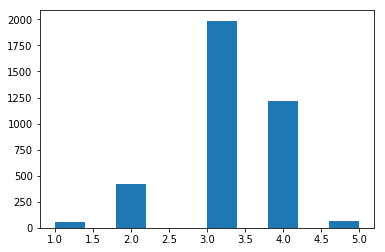

In [38]:
# compare to actual ratings of the user
plt.hist(review_r[review_r.user_id == 'CxDOIDnH8gp9KXzpBHJYXw'].stars);
review_r[review_r.user_id == 'CxDOIDnH8gp9KXzpBHJYXw'].stars.mean()

As shown, the predicted ratings from NMF without bias show reasonable results. Predicted ratings center around rating of 3-4.5, with a mean of 3.41 and a range of 0.44 to 6.42, a close match of the actual ratings centerd around 3-4 with a mean of 3.2 and a range of 1-5.
On the other hand, the predicted ratings for unseen users will just be the global mean, 3.74 computed from the trainset.

In [39]:
# %%time

# # parameter optimization with scikit-surprise NMF algorithm with no bias

# # cross validation to optimize parameters of NMF with no bias
# param_grid = {'n_factors': [10,20,30,50], 'n_epochs': [50],'biased': [False]}
# nmf_gs = GridSearchCV(NMF, param_grid, measures=['rmse'], cv=KFold(3, random_state=42), joblib_verbose=2)
# nmf_gs.fit(data_train) # gridsesarch optimization on the trainset, need to feed in a Dataset object not a trainset object

# # best RMSE score
# print(nmf_gs.best_score)
# # combination of parameters that gave the best RMSE score
# print(nmf_gs.best_params)

# nmf_gs_best = nmf_gs.best_estimator['rmse']  # algorithm with the optimized parameters
# nmf_gs_best.fit(training)
# pred_nmf_gs_best = nmf_gs_best.test(testing)
# accuracy.rmse(pred_nmf_gs_best)

### 2.2.4 NMF with bias terms

The bias terms can also be added to the non-negative matrix factorization (NMF) algorithm by setting 'biased=True' argument. https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.NMF

In [40]:
%%time
# NMF with bias

nmf_bias = NMF(n_factors=20, n_epochs = 30, biased=True, verbose=True) # initiate a NMF algorithm object

nmf_bias.fit(training) # training on the trainset
pred_nmf_bias = nmf_bias.test(testing) # predict ratings for the testset
accuracy.rmse(pred_nmf_bias) # compute RMSE score

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
RMSE: 1.9482
CPU times: user 6min 15s, sys: 11.5 s, total: 6min 27s
Wall time: 6min 32s


In [41]:
# extract global mean rating from trainset
mean = nmf_bias.trainset.global_mean

# user and item matrix with latent features
user_latent = nmf_bias.pu
item_latent = nmf_bias.qi
print(user_latent.shape)
print(item_latent.shape)

# user and item bias vector
user_bias = nmf_bias.bu
item_bias = nmf_bias.bi
print(user_bias.shape)
print(item_bias.shape)

(1435339, 20)
(188543, 20)
(1435339,)
(188543,)


[ 5.89603223  1.71586305  6.23627654  5.9394476  -5.9397852   6.06003575
  4.28527058  5.43576858  5.18346678  7.57055841]
(188543,)
mean predicted rating:  -0.5433499266548315
[(65015, 67527.0239170744), (137376, 64321.670564326036), (167175, 25227.546659139884), (127750, 18630.17202250898), (40850, 17710.198246873857), (21294, 17351.449101283684), (141401, 17096.82855359588), (57237, 16800.042225874844), (167192, 15641.087970833023), (47728, 15156.937483162656)]
[(170984, -13508.761842518981), (56217, -15160.541752681833), (130930, -16132.128153896101), (166761, -18353.78183879424), (50808, -28658.302545993367), (131745, -49421.46480774146), (58147, -50415.50224128151), (44169, -65246.72408060015), (116287, -131742.95829348254), (92668, -962490.7018024112)]


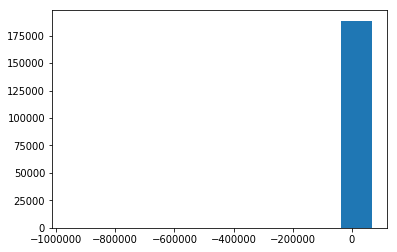

In [42]:
# spot check-known user

u_id = training.to_inner_uid('CxDOIDnH8gp9KXzpBHJYXw')
prediction = mean + user_bias[u_id] + item_bias + np.dot(user_latent[u_id,:],item_latent.T)
print(prediction[:10])
print(prediction.shape)
print("mean predicted rating: ", sum(prediction)/len(prediction))

# # adjust for rating offset
# prediction -= svd_bias.trainset.offset # Here: offset = 0 

# plot distribution of the predicted ratings
plt.hist(prediction);

# sort and look at the top 10 highest and lowest ratings
prediction_s = list(zip(np.arange(len(prediction)),prediction))
prediction_s = sorted(prediction_s, key=lambda x: x[1], reverse=True)
print(prediction_s[:10]) # 10 highest predicted ratings
print(prediction_s[-10:]) # 10 lowest predicted ratings

[ 4.25033682  0.07035844  4.59054878  4.29378253 -7.58550062  4.41430809
  2.63954632  3.78981324  3.53773654  5.92488064]
(188543,)
67525.37819076964 -2.1881481553474895
[(65015, 67525.37819076964), (137376, 64320.02483802127), (167175, 25225.900932835117), (127750, 18628.526296204214), (40850, 17708.55252056909), (21294, 17349.803374978917), (141401, 17095.18282729111), (57237, 16798.396499570077), (167192, 15639.442244528256), (47728, 15155.291756857889)]
[(170984, -13510.407568823748), (56217, -15162.1874789866), (130930, -16133.773880200868), (166761, -18355.427565099006), (50808, -28659.948272298134), (131745, -49423.11053404622), (58147, -50417.14796758635), (44169, -65248.36980690491), (116287, -131744.60401978734), (92668, -962492.3475287161)]


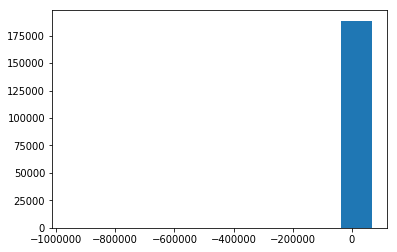

In [44]:
# spot check-unknown user

prediction = mean + item_bias
print(prediction[:10])
print(prediction.shape)
print(max(prediction), sum(prediction)/len(prediction))

# # adjust for rating offset
# prediction -= svd_bias.trainset.offset # Here: offset = 0

# plot distribution of the predicted ratings
plt.hist(prediction);

# sort and look at the top 10 highest and lowest ratings
prediction_s = list(zip(np.arange(len(prediction)),prediction))
prediction_s = sorted(prediction_s, key=lambda x: x[1], reverse=True)
print(prediction_s[:10]) # 10 highest predicted ratings
print(prediction_s[-10:]) # 10 lowest predicted ratings

3.2187750735490774

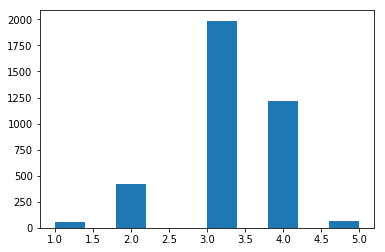

In [45]:
# compare to actual ratings of the user
plt.hist(review_r[review_r.user_id == 'CxDOIDnH8gp9KXzpBHJYXw'].stars);
review_r[review_r.user_id == 'CxDOIDnH8gp9KXzpBHJYXw'].stars.mean()

As shown, non-negative matrix factorization with bias terms give much worse results. 
The predicted ratings from NMF with bias terms span a much wider range from -962490 to 67527, with a mean of -0.54 , way off from the actual ratings centerd around 3-4 with a mean of 3.2 and a range of 1-5. 
On the other hand, the predicted ratings for unseen users also distribute in a wide range of -962492 to 67525, with a mean of -2.19, not a match of the global mean of 3.74 either.<br>
Here, the benefit of non-negative matrix factorization is thrown off by having the bias items, especially the large item bias terms. As a result, the predicted ratings are no longer non-negative. Having a large regularization terms on user and item bias parameters will help, but this will just push it back to the NMF algorithm without bias. Therefore, NMF with bias will not be used.

### 2.2.5 non-negative matrix factorization using scikit-learn.decomposition.NMF

In order for this to work, the user x business rating matrix needs to be extracted from the review dataframe first.
As shown below, using pandas pivot method to pviot the 'review' dataframe by 'user_id' and 'business_id' doesn't work due to the large memory required to process and store the resulting user x business matrix. Instead, the 'review' dataframe is pivoted directly into a sparse matrix and the available ratings are stored as values in the sparse matrix.

In [46]:
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


#### using pandas pivot to convert 'review' dataframe to the 'user_id' x 'business_id' matrix [did not work out] 

In [55]:
# # trying only with the first 50,000 rows
# matrix_reduced = review_r[:50000].pivot(index='user_id', columns='business_id', values='stars')

In [56]:
# print(matrix_reduced.shape)
# print(matrix_reduced.info())

# # check the target matrix dimension
# print(len(review_r.user_id.value_counts()))
# print(len(review_r.business_id.value_counts()))

# # check sparsity
# print("The non-NaN entries in the target matrix is {}%".format(len(review_r)*100/(len(review_r.user_id.value_counts())*len(review_r.business_id.value_counts()))))

(20076, 30915)
<class 'pandas.core.frame.DataFrame'>
Index: 20076 entries, ---PLwSf5gKdIoVnyRHgBA to zzq0TgPc5-b3-7XKt6fwJA
Columns: 30915 entries, --6MefnULPED_I942VcFNA to zzwhN7x37nyjP0ZM8oiHmw
dtypes: float64(30915)
memory usage: 4.6+ GB
None
1518168
188593
The non-NaN entries in the target matrix is 0.002094537148506619%


As shown, the matrix_reduced created by only pivoting the first 50,000 rows is already taking 4.6+ GB, and the matrix_reduced shape is 20076 x 30915.<br>
The actual matrix shape will be len(review.user_id.value_counts()) x len(review.business_id.value_counts()), that is 1518168 x 188593, 461 times larger. Therefore, it's impossible given the space (memory) constrain. <br>

Alternatively, the target matrix is very sparse, therefore to make it work with the memory constrain, the 'stars' rating in the 'review' dataframe needs to be pivoted into a sparse matrix directly, by 'user_id' and 'business_id'. 

#### pivot directly into a sparse matrix

In [47]:
# define method for pivoting dataframe into a sparse matrix directly
# version: python 3.6.5, pandas 0.23.3, numpy 1.15.0 scipy 1.1.0

from scipy.sparse import csr_matrix
from pandas.api.types import CategoricalDtype

# return the resulting sparse matrix only
def df_pivot_sparse_matrix_simple(df, idx, col, val):
    """pivot a pandas dataframe into sparse matrix directly using scipy.sparse.csr_matrix and return the resulting sparse matrix. 
    necessary when the df is large and pandas pivot (dense matrix) doesn't work due to space (memory) constrain. 
    ---
    input
    df: the pandas dataframe of interest
    idx: the column name of the df to be used as the index in the sparse matrix;
    col: the column name of the df to be used as the column in the sparse matrix;
    val: the column name of the df to be used as the actual value in the sparse matrix;
    ---
    note: there should be only one unique value of each idx, col combination
    """
    x = df[idx].astype(CategoricalDtype(ordered=True)).cat.codes
    y = df[col].astype(CategoricalDtype(ordered=True)).cat.codes
    return csr_matrix((df[val].values, (x, y)), shape=(df[idx].nunique(), df[col].nunique()))


# return the resulting sparse matrix along with the mapping dictionaries of matrix indices to the orignial values in the corresponding columns of df
def df_pivot_sparse_matrix(df, idx, col, val):
    """pivot a pandas dataframe into sparse matrix directly using scipy.sparse.csr_matrix and return the resulting sparse matrix, 
    necessary when the df is large and pandas pivot (dense matrix) doesn't work due to space (memory) constrain. 
    ---
    input
    df: the pandas dataframe of interest
    idx: the column name of the df to be used as the index in the sparse matrix;
    col: the column name of the df to be used as the column in the sparse matrix;
    val: the column name of the df to be used as the actual value in the sparse matrix;
    ---
    return:
    sparse_matrix: the resulting sparse matrix
    map_idx: the dictionary to map the unique values in the idx column of the original df to the numerical row indices of the sparse matrix 
    map_col: the dictionary to map the uniqe values in the col column of the original df to the numerical column indices of the sparse matrix 
    ---
    note: there should be only one unique value of each idx, col combination
    """
    idx_c = CategoricalDtype(sorted(df[idx].unique()),ordered=True) # find unique values in the idx column and define as a categorical type
    col_c = CategoricalDtype(sorted(df[col].unique()),ordered=True) # find unique values in the col column and define as a categorical type

    x = df[idx].astype(idx_c).cat.codes # cast columns to the newly created categorical type and access the underlying integer codes (corresponding numbering of the categories)
    y = df[col].astype(col_c).cat.codes 
    sparse_matrix = csr_matrix((df[val].values, (x, y)), \
                           shape=(len(idx_c.categories), len(col_c.categories))) # map to the sparse matrix
    
    map_idx = dict(zip(list(idx_c.categories),np.arange(len(idx_c.categories)))) # create the mapping dictionaries
    map_col = dict(zip(list(col_c.categories),np.arange(len(col_c.categories))))
                               
    return sparse_matrix, map_idx, map_col

In [48]:
%%time
# convert to sparse matrix
matrix, map_user_id, map_business_id = df_pivot_sparse_matrix(review_r, 'user_id', 'business_id', 'stars')

CPU times: user 8.16 s, sys: 1.12 s, total: 9.28 s
Wall time: 10.1 s


In [49]:
# inspect the sparse matrix

# check shape
print("matrix shape:", matrix.shape)

# check memory use
print("memory use: {} Mb".format((matrix.data.nbytes + matrix.indptr.nbytes + matrix.indices.nbytes)*0.125*1e-6))

# check data type
print(matrix.dtype)

# check non-NaN values
print(len(matrix.data))
print(review_r.stars.notnull().sum())

matrix shape: (1518168, 188593)
memory use: 9.7545725 Mb
int64
5996992
5996992


As shown, now the number of ratings in the sparse matrix is consistent with the number of non-NaN ratings in the 'review' dataset. 

In [50]:
# inspect the mapping dictionaries
print(list(map_user_id.items())[:5])
print(list(map_business_id.items())[:5])

[('---1lKK3aKOuomHnwAkAow', 0), ('---89pEy_h9PvHwcHNbpyg', 1), ('---94vtJ_5o_nikEs6hUjg', 2), ('---PLwSf5gKdIoVnyRHgBA', 3), ('---cu1hq55BP9DWVXXKHZg', 4)]
[('--1UhMGODdWsrMastO9DZw', 0), ('--6MefnULPED_I942VcFNA', 1), ('--7zmmkVg-IMGaXbuVd0SQ', 2), ('--8LPVSo5i0Oo61X01sV9A', 3), ('--9QQLMTbFzLJ_oT-ON3Xw', 4)]


In [57]:
# compute global mean of ratings based on the trainset
global_mean_train = trainset.stars.mean()
global_mean_train

3.736666832181768

Note: the training data doesn't include all users and all restaurants, and this will be handled using a fallback rating: for users and restaurants that are not present in the trainset, return the global mean as the prediction. Global mean is computed from the trainset.

In [58]:
# convert trainset to sparse matrix
trainset_m, train_map_user, train_map_business = df_pivot_sparse_matrix(trainset, 'user_id', 'business_id', 'stars')
# testset_m, test_map_user, test_map_business = df_pivot_sparse_matrix(testset, 'user_id', 'business_id', 'stars')

In [59]:
# compute performance

def compute_performance(testset, user_matrix, item_matrix, user_mapper, item_mapper):
    """ Predict and compute the RMSE(root mean squared error) of the predicted ratings vs true ratings on the testset
    Return the RMSE and the list of predicted ratings
    """
    y_true = list(testset.stars.values)
    y_pred = list()
    
    for idx in testset.index:
        u, b, r = testset.loc[idx, ['user_id','business_id','stars']]
        if (u in user_mapper) and (b in item_mapper):
            u_i, b_i = user_mapper[u], item_mapper[b]
            r_pred = np.dot(user_matrix[u_i,:], item_matrix[:,b_i])
        else: 
            r_pred = global_mean_train  # return global mean rating for unseen user or restaurant
        y_pred.append(r_pred)
    
    assert len(y_true) == len(y_pred)
    mse = mean_squared_error(y_true, y_pred)
    return np.sqrt(mse), y_pred

In [62]:
%%time

# initiate a NMF algorithm and fit to the trainset
model = NMF(n_components=20, tol=5e-5)
W = model.fit_transform(trainset_m) # W is the user x latent feature matrix
H = model.components_ # H is the latent feature x item matrix

print(W.shape)
print(H.shape)

(1435047, 20)
(20, 188544)
CPU times: user 3min 20s, sys: 15.9 s, total: 3min 36s
Wall time: 3min 31s


In [63]:
%%time

# test on the testset
rmse, pred = compute_performance(testset, W, H, train_map_user, train_map_business)
print(rmse) # RMSE on the testset

3.723006268306729
CPU times: user 6min 53s, sys: 9.28 s, total: 7min 2s
Wall time: 7min 10s


mean, max and min predicted ratings are: 0.575629918370714 11.537371553177916 0.0
[0.00528969 0.07732393 0.16965126 0.85649762 3.73666683 3.73666683
 3.73666683]


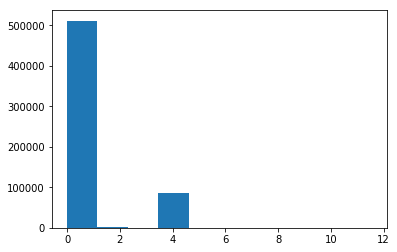

In [64]:
# look at the predicted ratings of the testset
plt.hist(pred);
print("mean, max and min predicted ratings are:", sum(pred)/len(pred), max(pred), min(pred))
print(np.quantile(pred,[0.5,0.75,0.8,0.85,0.9,0.95,0.99]))

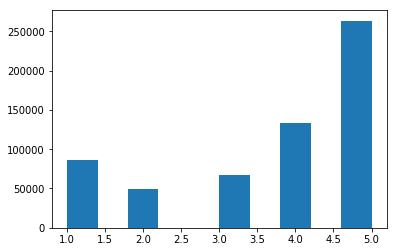

In [65]:
# compare to the actual ratings of the testset
plt.hist(testset.stars);

Max predicted rating is 12.832, average predicted rating is 0.58. The 'rmse' is 3.723.
As shown, the predicted ratings are bimodally distributed in the range of 0-1 and 3-4, too far off from the actual distribution.

# 3. The collaborative filtering module

As shown above, both the SVD algorithm with bias terms and the NMF algorithm without bias terms from the scikit-surprise package serves for the matrix factorization purpose here, but the SVD algorithm provides a better performance. Not only does it have the lowest RMSE, but also, instead of returning a global mean rating for all restaurants in the case of unseen users, it actually returns an item-specific rating for individual restaurants as a result of having the item bias vector.

Therefore, the SVD algorithm with bias terms is selected as the algorithm for collaborative filtering module, the parameters are first optimized via cross validation on the trainset, the algorithm is then updated and tested on the testset, and finally the algorithm is re-trained on the entire dataset and saved to file for use in the collaborative module. 

## 3.1 Re-train algorithm on entire dataset and save to file

In [73]:
# %%time

# # optimized SVD algorithm re-train on the entire dataset

# # load the entire dataset into Surprise
# svd_bias = SVD(n_factors=20, n_epochs = 50, biased=True, verbose=True) # initiate a SVD algorithm object with the bias terms
# data = Dataset.load_from_df(review_r[['user_id','business_id','stars']], reader)
# svd_bias.fit(data.build_full_trainset()) # prepare a trainset object out of the entire dataset to feed to .fit() method
# pred_svd_bias = svd_bias.test(data.construct_testset(data.raw_ratings)) # prepare a testset object out of the entire dataset to feed to .test() method
# accuracy.rmse(pred_svd_bias) # compute RMSE score

In [74]:
# check there is no offset term (otherwise all prediction need to be adjusted by the offset)
assert svd_bias.trainset.offset == 0

# wrap all useful info from the trained model in a dictionary and pickle to file
svd_trained_info = {'user_latent': svd_bias.pu,
                    'item_latent': svd_bias.qi,
                    'user_bias': svd_bias.bu,
                    'item_bias': svd_bias.bi,
                    'mean_rating': svd_bias.trainset.global_mean,
                    'userid_to_index': svd_bias.trainset._raw2inner_id_users,
                    'itemid_to_index': svd_bias.trainset._raw2inner_id_items
                   }

In [75]:
%%time

# save all necessary information for prediction from the trained svd_bias model
with open('svd_trained_info.pkl', 'wb') as f:
    pickle.dump(svd_trained_info, f)

# save all the information regarding the trained svd_bias model as a backup (this file will be large)
with open('svd_bias_model_trained.pkl','wb') as f:
    pickle.dump(svd_bias, f)

CPU times: user 9.98 s, sys: 2.75 s, total: 12.7 s
Wall time: 14.1 s


## 3.2 Implementation

In [81]:
class Recommender:
    
    def __init__(self, n=5, original_score=False):
        """initiate a Recommender object by passing the desired number of recommendations to make, the default number is 10.
        By default, the adjusted score will be used for ranking; To rank by the original average rating of the restaurant, pass original_score=True
        """
        self.n = n # number of recommendations to make, default is 5
        self.original_score = original_score # boolean indicating whether the original average rating or the adjusted score is used
        # initiate a list of column names to display in the recommendation results
        self.column_to_display = ['state','city','name','address','attributes.RestaurantsPriceRange2','cuisine','style','review_count','stars','adjusted_score']
        
        # initiate the list of recommendations to be the entire catalog of the 'business' dataframe sorted by the score of interest
        if self.original_score:  # set sorting criteria to the originial star rating
            score = 'stars'
        else:  # set sorting criteria to the adjusted score
            score = 'adjusted_score'
        self.recomm = business.sort_values(score, ascending=False)
        
    def display_recommendation(self):
        """ Display the list of top n recommended restaurants
        """
        # limit the list of recommendation to only top n at max
        if self.n < len(self.recomm):
            self.recomm = self.recomm.iloc[:self.n]
        if len(self.recomm) == 0:
            print("Sorry, there is no matching recommendations.")
        else: 
            print("The top {} recommended restaurants matching your keywords are".format(self.n))
            print(self.recomm[self.column_to_display])
    
    # personalized collaborative-based filtering recommender module
    def collaborative(self, user_id=None):
        """Passing of user_id is required if personalized recommendation is desired.
        """
        
        self.user_id = user_id # user_id for personalized recommendation using collaborative filtering 
        if self.user_id is None:
            print("no user_id is provided!")
            return None
        if len(self.user_id) != 22:
            print("invalid user id!")
            return None
        
        # initiate every time the module is called
        self.recomm = business # start with the entire 'business' catalog
        if 'predicted_stars' in self.recomm.columns:
            self.recomm.drop('predicted_stars', axis=1, inplace=True) # delete the column of 'predicted_stars' if already present
        self.column_to_display = ['state','city','name','address','attributes.RestaurantsPriceRange2',\
                                  'cuisine','style','review_count','stars','adjusted_score'] # reset the columns to display
        
        # load and extract the necessary info fro the trained matrix factorization algorithm
        with open('svd_trained_info.pkl', 'rb') as f:
            svd_trained_info = pickle.load(f)
        user_latent = svd_trained_info['user_latent']
        item_latent = svd_trained_info['item_latent']
        user_bias = svd_trained_info['user_bias']
        item_bias = svd_trained_info['item_bias']
        r_mean = svd_trained_info['mean_rating'] # global mean of all ratings
        userid_to_idx = svd_trained_info['userid_to_index']
        itemid_to_idx = svd_trained_info['itemid_to_index']
        
        # predict personalized restaurant ratings for the user_id of interest
        if self.user_id in userid_to_idx:
            u_idx = userid_to_idx[self.user_id]
            pred = r_mean + user_bias[u_idx] + item_bias + np.dot(user_latent[u_idx,:],item_latent.T)
        else: 
            print("sorry, no personal data available for this user_id yet!")
            print("Here is the generic recommendation computed from all the users in our database:")
            pred = r_mean + item_bias
        
        # pairing the predicted ratings with the business_id by matching the corresponding matrix indices of the business_id
        prediction = pd.DataFrame(data=pred, index=itemid_to_idx.values(), columns=['predicted_stars']) 
        prediction.index.name = 'matrix_item_indice'
        assert len(prediction) == len(pred)
        prediction['business_id'] = list(itemid_to_idx.keys())
        
        # filter to unrated business_id only by the user_id of interest if a personal history is available
        if self.user_id in userid_to_idx:       
            unrated_busi = set(review_r.business_id).difference(set(review_r[review_r.user_id == self.user_id].business_id))
            prediction = prediction.set_index('business_id').loc[unrated_busi].reset_index()
        
        # inner-join the prediction dataframe with the recommendation catalog on 'business_id' to retrieve all relevant business informations
        # note: the .merge step needs to be performed prior to extracting the top n
        # because many of the 'business_id' in the review dataframe are not restaurant-related, therefore not present in the 'business' catalog
        self.recomm = self.recomm.merge(prediction, on='business_id', how='inner') 
        
        # sort the prediction by the predicted ratings in descending order
        self.recomm = self.recomm.sort_values('predicted_stars', ascending=False).reset_index(drop=True)
        
        # add 'predicted_stars' to the list of columns to display
        self.column_to_display.insert(0, 'predicted_stars') 
        
        # display the list of top n recommendations
        self.display_recommendation()
        
        return self.recomm

## 3.2 Testing

In [69]:
%%time

# initiate a Recommender object
kw = Recommender(n=5)

# test0: display only (same as no keywords)
print("------\nresult from test0 (display only): ")
kw.display_recommendation()

# test1: no user id input
print("------\nresult from test1 (no user id input): ")
kw.collaborative();

# test 2: invalid user id input
print("------\nresult from test2 (invalid user id input): ")
kw.collaborative(user_id='928402');

------
result from test0 (display only): 
The top 5 recommended restaurants matching your keywords are
      state             city                name  \
7464     AZ          Phoenix     Little Miss BBQ   
31910    NV        Las Vegas        Brew Tea Bar   
45401    NV        Las Vegas          Gelatology   
7784     NV  North Las Vegas        Poke Express   
28162    NV        Las Vegas  Meráki Greek Grill   

                            address  attributes.RestaurantsPriceRange2  \
7464           4301 E University Dr                                2.0   
31910  7380 S Rainbow Blvd, Ste 101                                1.0   
45401  7910 S Rainbow Blvd, Ste 110                                1.0   
7784        655 W Craig Rd, Ste 118                                2.0   
28162  4950 S Rainbow Blvd, Ste 160                                2.0   

                                   cuisine               style  review_count  \
7464                              barbeque         restaura

In [70]:
%%time

# test 3: valid user id (no user data)
print("------\nresult from test3 (valid user id --- no user review data): ")
kw.collaborative(user_id='-NzChtoNOw706kps82x0Kg');

------
result from test3 (valid user id --- no user review data): 
sorry, no personal data available for this user_id yet!
Here is the generic recommendation computed from all the users in our database:
The top 5 recommended restaurants matching your keywords are
   predicted_stars state       city                            name  \
0         4.965263    WI    Madison         The Conscious Carnivore   
1         4.950097    AZ    Gilbert              Dreamland Bouncers   
2         4.949568    NV  Henderson               Cakes On the Move   
3         4.943407    NV  Las Vegas  Tokyo Peking Asian Restaurants   
4         4.941919    AZ    Phoenix            Binkley's Restaurant   

                          address  attributes.RestaurantsPriceRange2  \
0      3236 University Ave, Ste A                                2.0   
1   3317 S Higley Rd, Ste 114-251                                NaN   
2           1211 Santa Helena Ave                                2.0   
3  750 East Pyle Ave,

In [78]:
%%time

# test 4: valid user id (user has over 100 reviews)
print("------\nresult from test4 (valid user id --- user has over 100 reviews): ")
kw.collaborative(user_id='---1lKK3aKOuomHnwAkAow');

------
result from test4 (valid user id --- user has over 100 reviews): 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


The top 5 recommended restaurants matching your keywords are
   predicted_stars state       city                                 name  \
0         6.299853    NV  Las Vegas  Biwon Korean BBQ & Sushi Restaurant   
1         6.286108    NV  Henderson                            Egg Works   
2         6.220048    NV  Las Vegas               Capo's Italian Cuisine   
3         6.202842    AZ    Gilbert                   Brio Tuscan Grille   
4         6.131563    NV  Las Vegas                               Hikari   

                             address  attributes.RestaurantsPriceRange2  \
0                  2721 W Sahara Ave                                2.0   
1                10839 S Eastern Ave                                2.0   
2                  5675 W Sahara Ave                                2.0   
3  2150 E Williams Field Rd, Ste 118                                2.0   
4                  4175 S Buffalo Dr                                2.0   

                               

In [80]:
%%time

# test 5: valid user id (user has only one review)
print("------\nresult from test5 (valid user id --- user has only one review): ")
kw.collaborative(user_id='---89pEy_h9PvHwcHNbpyg');

------
result from test5 (valid user id --- user has only one review): 


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:79: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike


The top 5 recommended restaurants matching your keywords are
   predicted_stars state       city                  name  \
0         5.184999    NV  Las Vegas        Freed's Bakery   
1         5.179756    OH  Macedonia               Pronto!   
2         5.158894    NV  Las Vegas            Echo & Rig   
3         5.132254    NV  Las Vegas  Buddy V's Ristorante   
4         5.131649    NV  Las Vegas             Cloud Tea   

                       address  attributes.RestaurantsPriceRange2  \
0           9815 S Eastern Ave                                2.0   
1            223 E Highland Rd                                2.0   
2           440 S Rampart Blvd                                2.0   
3        3327 S Las Vegas Blvd                                2.0   
4  4045 S Buffalo Dr, Ste A108                                1.0   

                                             cuisine  \
0       bakeries, desserts, cupcakes, american (new)   
1                            italian, america